# Finding Crypto Trade Outliers

### Library Imports

In [29]:
import pandas as pd
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
RESAMPLING_FREQ_MINUTES = 1
ROLLING_WINDOW = (60 * RESAMPLING_FREQ_MINUTES) * 24 * 4 # Minutes x Hours x days = window
SIGMA = 5
TOP_K_OUTLIERS = 100

### Importing Price Data

In [31]:
file_name = "/Users/firstsingularity/DataspellProjects/sorrentum_ind/bulk.airflow.downloaded_1min.parquet.ohlcv.futures.v7.ccxt.binance.v1_0_0"
schema = None
partitioning = ds.partitioning(schema, flavor="hive")
dataset = pq.ParquetDataset(
    # Replace URI with path.
    file_name,
    #filesystem=filesystem,
    #filters=filters,
    partitioning=partitioning,
    use_legacy_dataset=False,
)
# To read also the index we need to use `read_pandas()`, instead of
# `read_table()`.
# See https://arrow.apache.org/docs/python/parquet.html#reading-and-writing-single-files.
columns = None
table = dataset.read_pandas(columns=columns)
df = table.to_pandas()

df.head()

,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
timestamp,,,,,,,,,,,
2022-10-01 00:00:00+00:00,1664582400000,5.406,5.406,5.401,5.403,20601.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:01:00+00:00,1664582460000,5.403,5.404,5.401,5.403,7417.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:02:00+00:00,1664582520000,5.403,5.407,5.403,5.407,4555.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:03:00+00:00,1664582580000,5.406,5.408,5.404,5.405,11194.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:04:00+00:00,1664582640000,5.404,5.406,5.404,5.405,1942.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10


### Calculating Close-Close Price Differences

In [32]:
df1 = df[['currency_pair', 'close']]
df1.index = df1.index.tz_convert('America/New_York')
df1 = df1.set_index(['currency_pair'], append=True)
df1 = df1.swaplevel(0, 1)
df1 = df1.sort_index()
df1.groupby([pd.Grouper(level='currency_pair'),
            pd.Grouper(level='timestamp', freq=str(RESAMPLING_FREQ_MINUTES) + 'T')]
           ).mean()
df1.head()

close
currency_pair timestamp                       
APE_USDT      2022-03-17 11:00:00-04:00  8.775
              2022-03-17 11:01:00-04:00  8.811
              2022-03-17 11:02:00-04:00  8.913
              2022-03-17 11:03:00-04:00  8.913
              2022-03-17 11:04:00-04:00  8.952

1. Drop unused columns
2. Convert UTC time to America/New York time
3. Convert DataFrame to MultiIndex of ('currency_pair', 'timestamp')
4. Resample 'timestamp' to minutes

In [33]:
ret = df1.groupby(level='currency_pair')['close'].pct_change().rename('ret')
grouped_rolling_ret = ret.groupby(level='currency_pair').rolling(ROLLING_WINDOW)
normalized_ret = ((ret - grouped_rolling_ret.mean().droplevel(0)) / grouped_rolling_ret.std().droplevel(0)).rename('normalized_ret')
normalized_ret.head()

currency_pair  timestamp                
APE_USDT       2022-03-17 11:00:00-04:00   NaN
               2022-03-17 11:01:00-04:00   NaN
               2022-03-17 11:02:00-04:00   NaN
               2022-03-17 11:03:00-04:00   NaN
               2022-03-17 11:04:00-04:00   NaN
Name: normalized_ret, dtype: float64

5. Calculate percent changes in closing prices
6. Compute a rolling norm on the percent changes

### Normalized Percent Change Plots

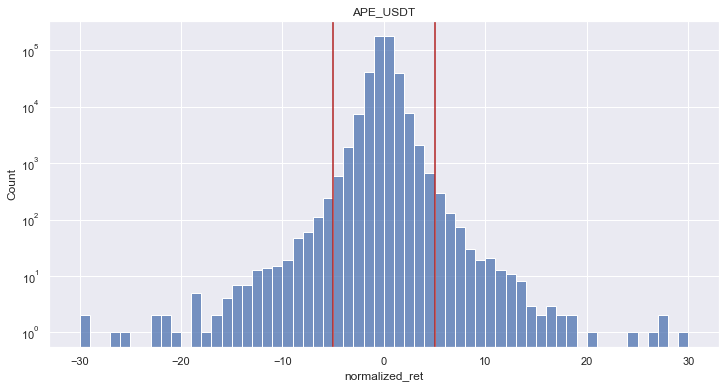

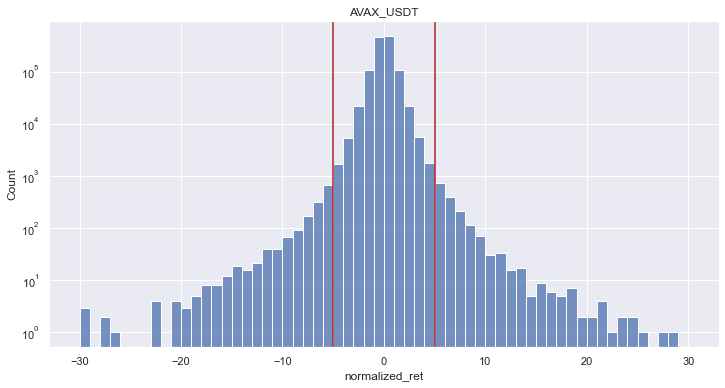

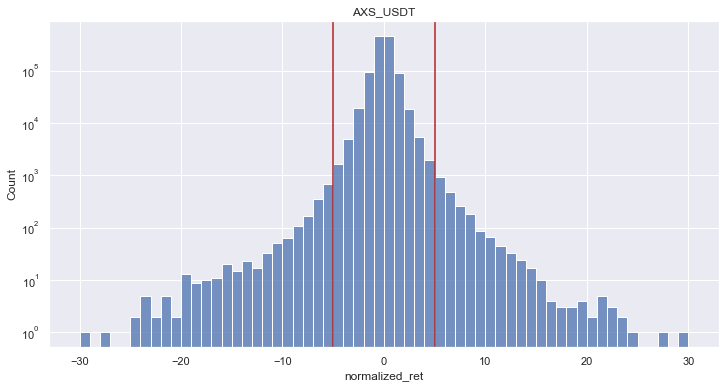

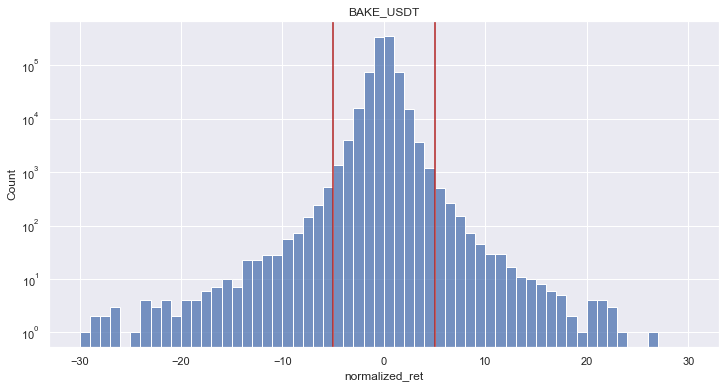

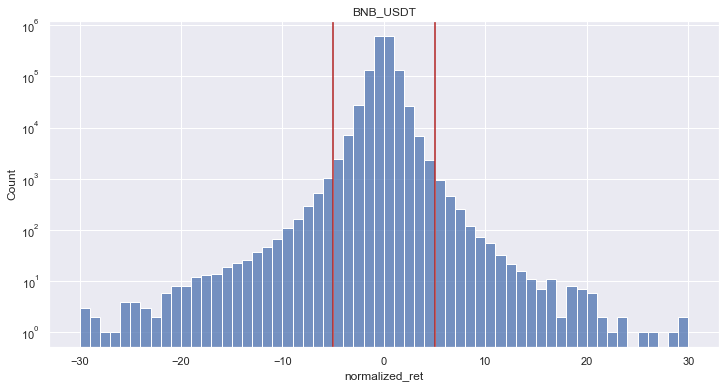

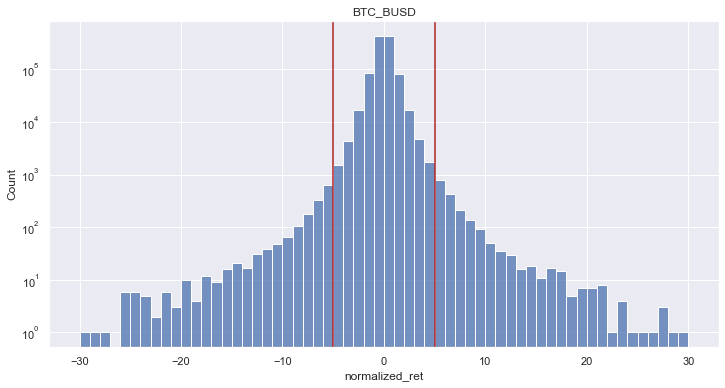

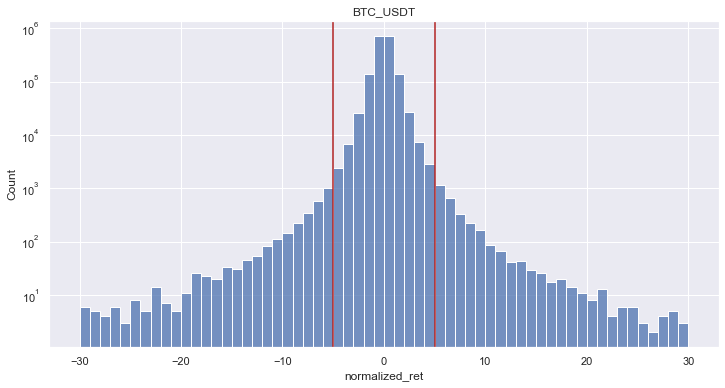

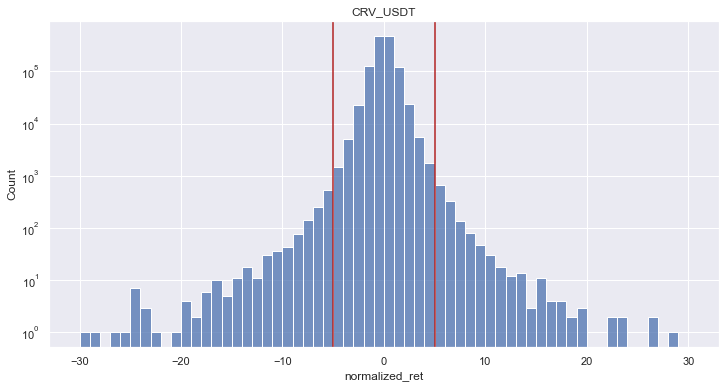

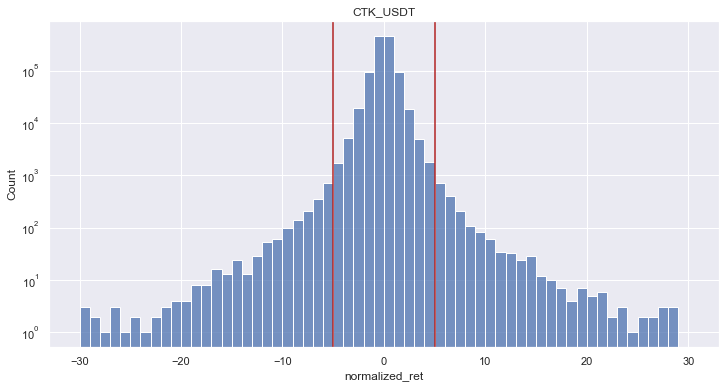

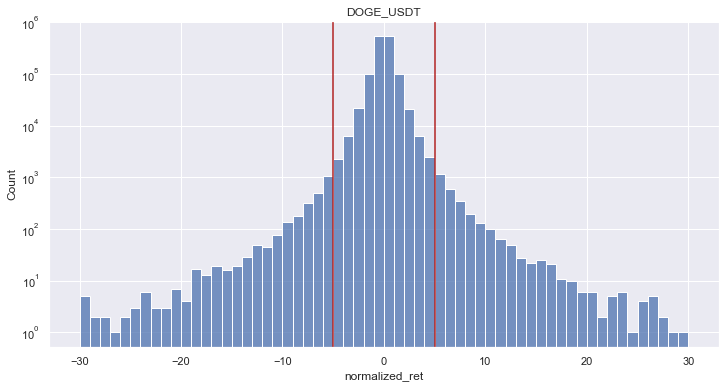

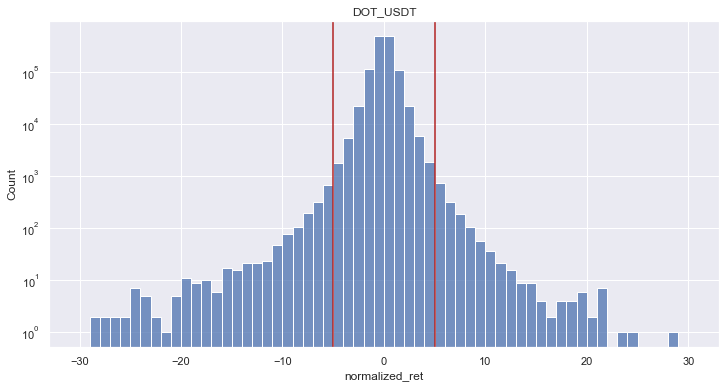

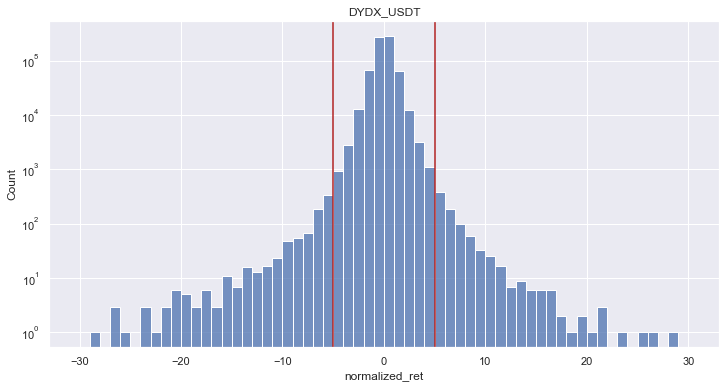

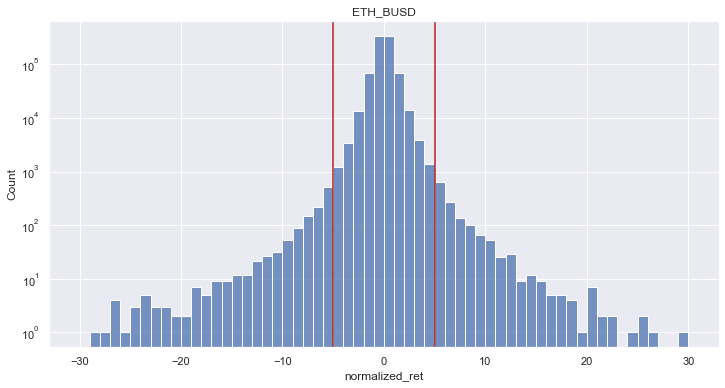

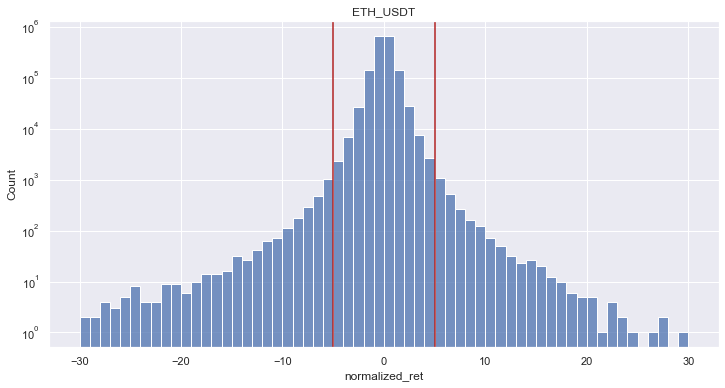

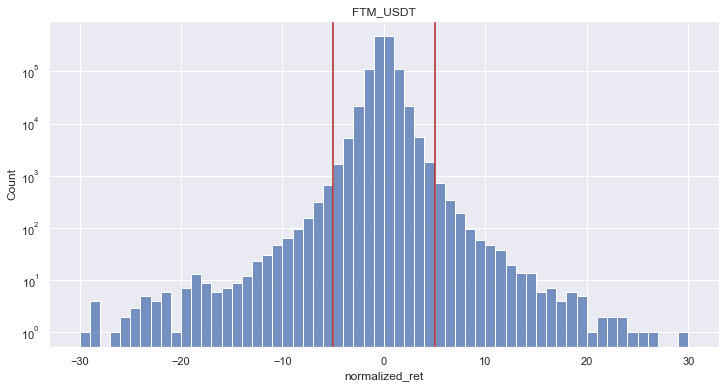

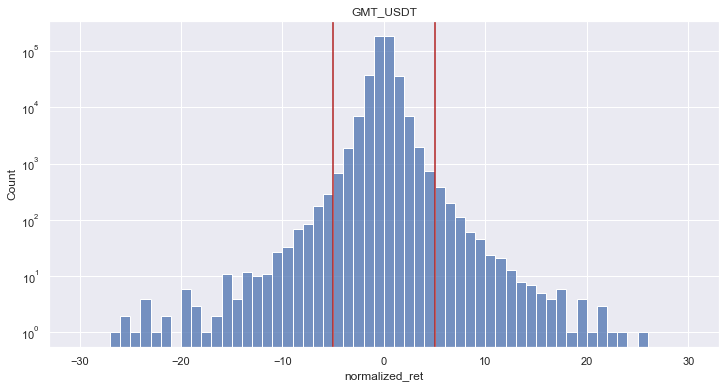

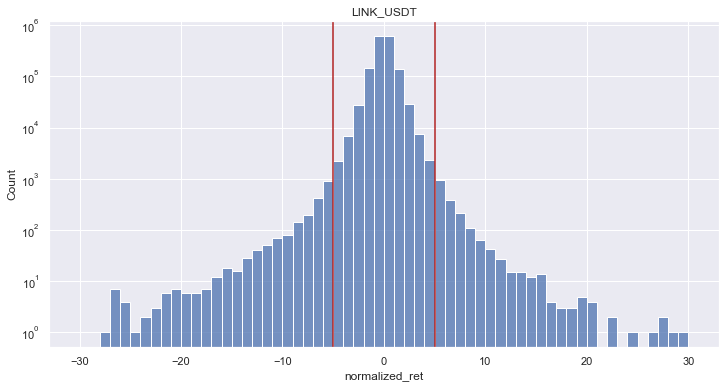

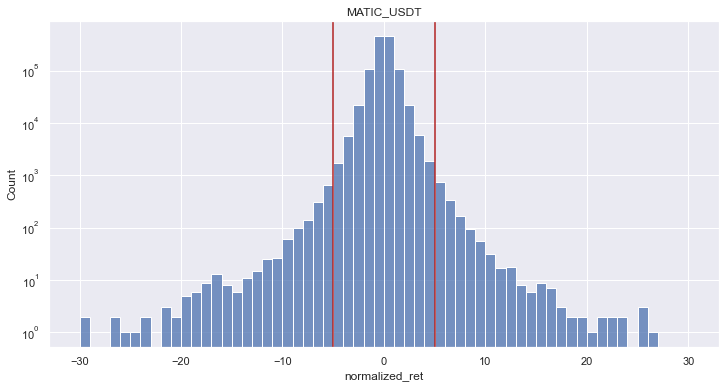

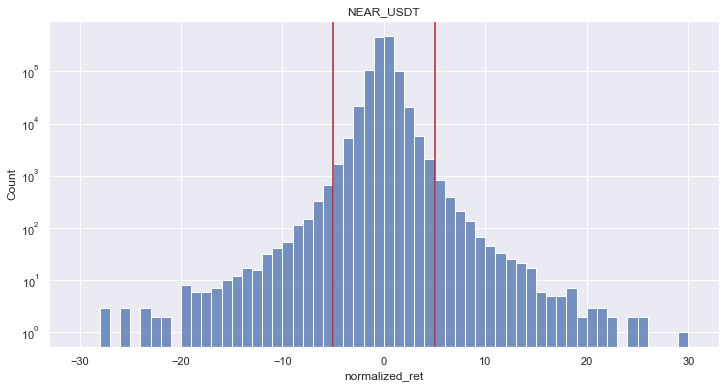

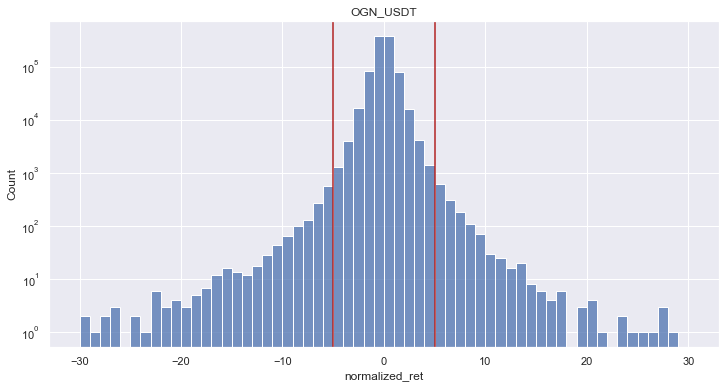

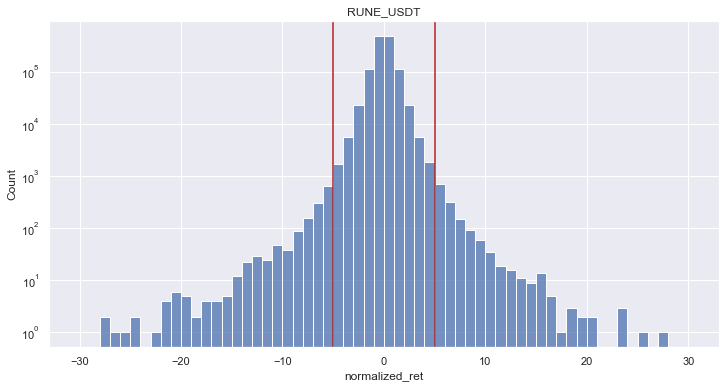

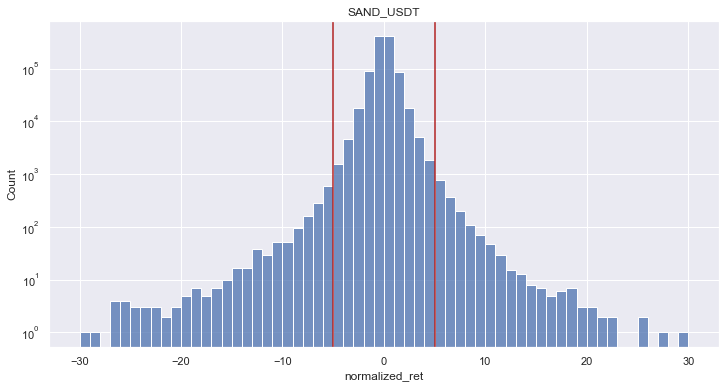

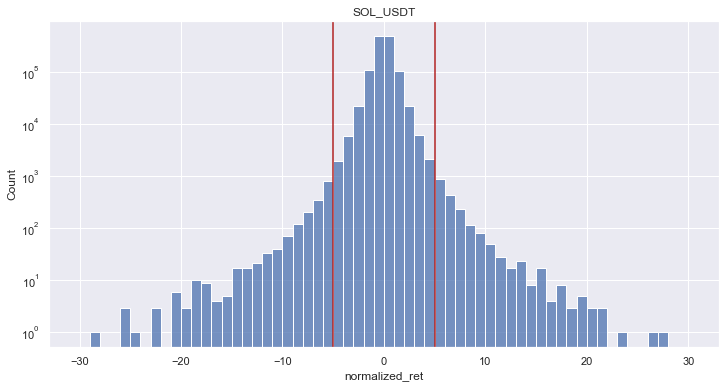

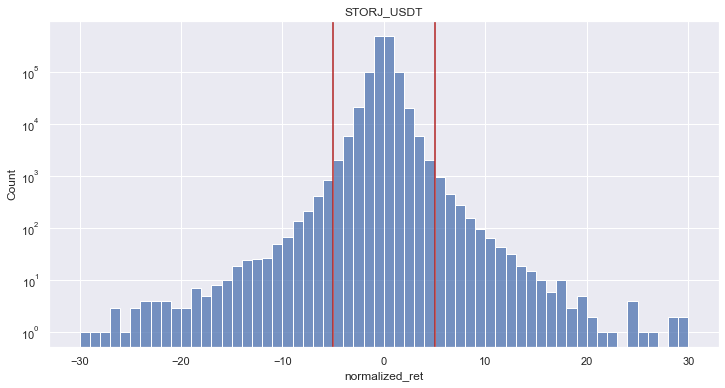

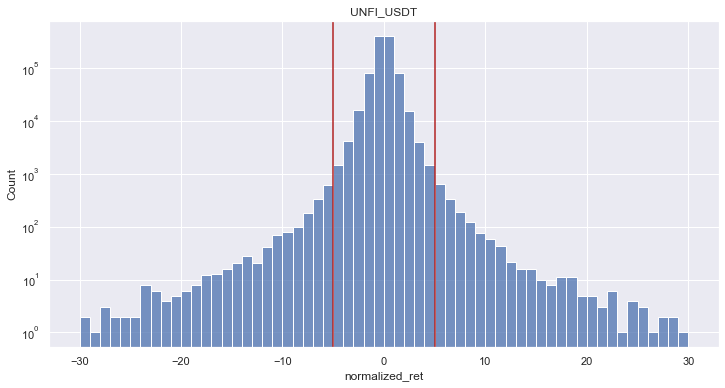

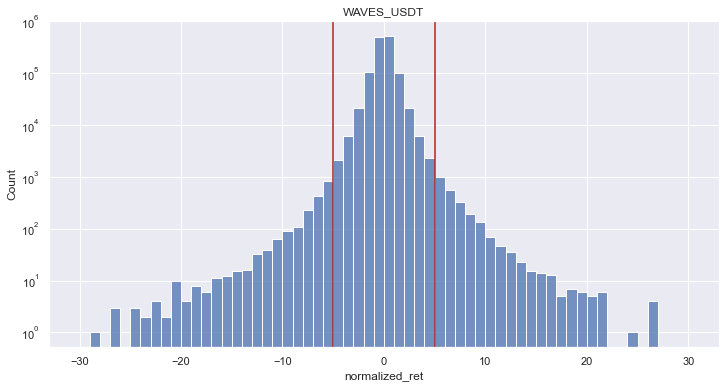

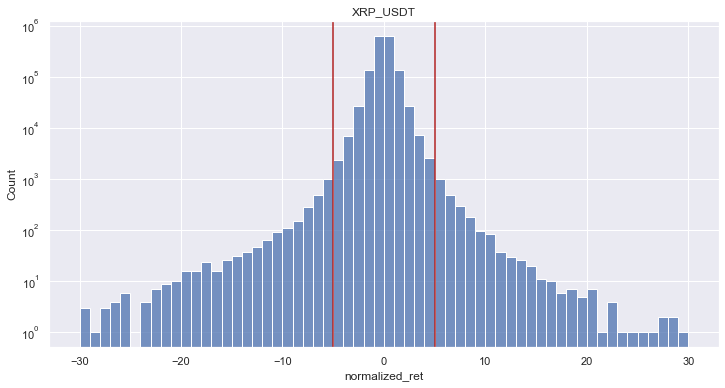

In [34]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 6)})

for currency_pair, frame in normalized_ret.groupby(level='currency_pair'):
    sns.histplot(x=frame, bins=range(-30, 31, 1)).set(title=currency_pair)
    plt.axvline(-SIGMA, color='firebrick')
    plt.axvline(SIGMA, color='firebrick')
    plt.yscale('log')
    plt.show()

The red lines indicate bounds for $5$ standard deviations from the mean price difference.

### Exporting Outlier Price Change Data

In [35]:
df2 = pd.concat([normalized_ret, ret], axis=1)
df2 = df2.rename(index={'currency_pair': 'asset'})
df2.head()

normalized_ret       ret
currency_pair timestamp                                          
APE_USDT      2022-03-17 11:00:00-04:00             NaN       NaN
              2022-03-17 11:01:00-04:00             NaN  0.004103
              2022-03-17 11:02:00-04:00             NaN  0.011576
              2022-03-17 11:03:00-04:00             NaN  0.000000
              2022-03-17 11:04:00-04:00             NaN  0.004376

In [36]:
df_extreme_outliers = df2[abs(df2['normalized_ret']) > SIGMA]
df_extreme_outliers.head()

normalized_ret       ret
currency_pair timestamp                                          
APE_USDT      2022-03-22 20:24:00-04:00        5.465560  0.019093
              2022-03-22 21:05:00-04:00       -5.704313 -0.019907
              2022-03-24 05:35:00-04:00      -12.560031 -0.039529
              2022-03-24 05:36:00-04:00        6.229590  0.019734
              2022-03-24 19:50:00-04:00       -5.730962 -0.017341

In [37]:
top_k_outliers = df_extreme_outliers
top_k_outliers = top_k_outliers.sort_values('normalized_ret', ascending=False, key=abs).head(100)
top_k_outliers.head()

,,normalized_ret,ret
currency_pair,timestamp,,
NEAR_USDT,2021-12-14 23:00:00-05:00,74.171557,0.728162
AXS_USDT,2022-11-13 08:40:00-05:00,71.697875,0.700039
GMT_USDT,2022-10-19 18:37:00-04:00,-60.461866,-0.079444
DOGE_USDT,2022-05-27 11:27:00-04:00,60.346060,0.122281
BTC_BUSD,2021-07-25 21:01:00-04:00,59.530066,0.075140


In [38]:
df_extreme_outliers.to_csv('outliers_window_{0}_sig_{1}.csv'.format(ROLLING_WINDOW, SIGMA))
top_k_outliers.to_csv('top_{0}_outliers_window_{1}_sig_{2}.csv'.format(TOP_K_OUTLIERS, ROLLING_WINDOW, SIGMA))